In [1]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os, sys

sys.path.insert(0, './../utils/')

# custom files 
import random_forest_regressor as rfr
import utilities as util
import validation as cv
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import train_test_split
from sklearn import cross_validation

%matplotlib inline

with open('../../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

/home/kristina/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
EPA_VISUAL = """
        SELECT
            avg(arithmetic_mean) as am,
            CONCAT(cast(EXTRACT(YEAR FROM SO2_daily.date_local) as string),
            '-',
            cast(EXTRACT(MONTH FROM SO2_daily.date_local) as string)) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` as SO2_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date ASC
        """
bq_assistant_SO2 = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_SO2_VISUAL = bq_assistant_SO2.query_to_pandas(EPA_VISUAL)

In [3]:
df_SO2_VISUAL.head()

,am,date
0,3.356863,1990-1
1,2.150394,1990-10
2,3.109342,1990-11
3,4.620892,1990-12
4,2.510095,1990-2


Text(0.5,1,'SO2 arithmetic mean between 1999 & 2008')

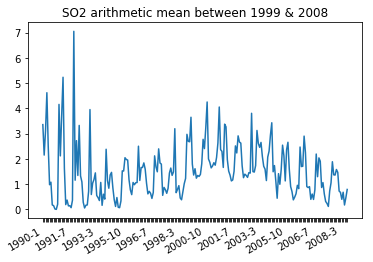

In [4]:
# plot original data 
fig, ax = plt.subplots()
ax.plot(df_SO2_VISUAL['date'], df_SO2_VISUAL['am'])
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
n = 20
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('SO2 arithmetic mean between 1999 & 2008')

In [5]:
EPA_QUERY = """
        SELECT
            avg(arithmetic_mean) as am,
            CONCAT(cast(EXTRACT(YEAR FROM SO2_daily.date_local) as string),
            cast(EXTRACT(MONTH FROM SO2_daily.date_local) as string), 
            cast(EXTRACT(DAY FROM SO2_daily.date_local) as string)) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` as SO2_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_SO2 = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_SO2 = bq_assistant_SO2.query_to_pandas(EPA_QUERY)

In [6]:
df_SO2.head()

,am,date
0,0.111039,200899
1,0.301470,200898
2,1.000000,200897
3,2.007143,200896
4,1.962987,200895


In [7]:
# find optimum regressor
regr = rfr.find_regressor(df_SO2['date'].as_matrix().reshape(-1,1), df_SO2['am'].values)
regr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.5s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.6s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.6s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   1.9s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.1s finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [8]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_SO2['date'].to_frame(), df_SO2['am'].values, test_size=0.33, random_state=42)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [9]:
cv.MSE(y_test, y_pred)

1.530219822770318

In [10]:
tss_score = cv.Cross_Validation(df_SO2['date'].to_frame(), df_SO2['am'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 2.7354901197154247 
